In [1]:
%reload_ext autoreload
%autoreload 2



%matplotlib inline

import random
from natsort import natsorted
import os

os.chdir("../")


In [2]:

from glob import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
from utils.dataset_utils import preprocess
from segmentation.road_segmenter import Segment
import cv2

from attention_manager import AttentionManager
print(os.getcwd())

2024-02-05 15:22:47.766261: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-05 15:22:47.940809: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-05 15:22:47.946029: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/xchen/miniconda3/envs/udacity-attention/lib/python3.8/site-packages/cv2/../../../../lib:

/home/xchen/Projects/temp/udacity-test-generation


174


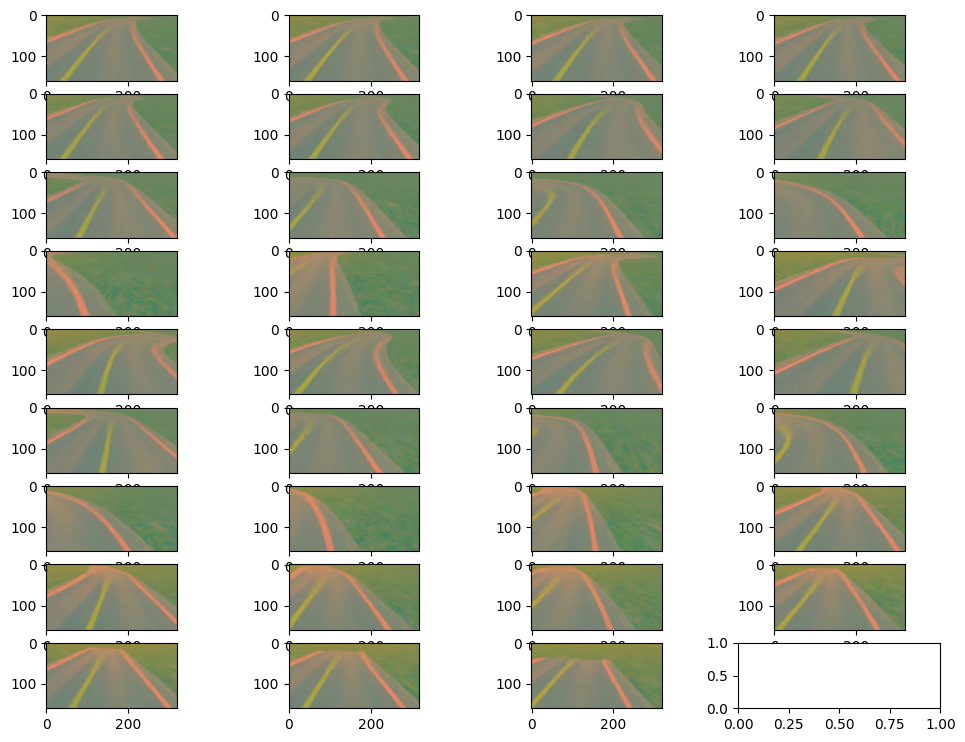

In [3]:
simulation_name = "simulations/24-01-30-12-39-XAI-seed=14-num-episodes=20-agent=supervised-num-control-nodes=8-max-angle=70/episode8"
image_names_list = natsorted(glob(os.path.join( simulation_name, '*.jpg')))
image_list = list(map(Image.open, natsorted(glob(os.path.join(simulation_name, '*.jpg')))))
index_step = 5
print(len(image_list))
"""
plt.subplot(1,2,1)
plt.imshow(image_list[0])
plt.subplot(1,2,2)
plt.imshow(preprocess(np.asarray(image_list[0])))
"""
images = image_list[::index_step]
processed_image = []
processed_image_yuv = []
ncol = 4
nrow = 9
f, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=(12, 9))

for i,image in enumerate(image_list[::index_step]):

    img = preprocess(np.asarray(image), if_yuv = False)
    img_yuv = preprocess(np.asarray(image), if_yuv = True)
    
    processed_image.append(img)
    processed_image_yuv.append(img_yuv)
    ax[int((i-i%ncol)/ncol), i%ncol].imshow(img_yuv)  #

# Heat maps

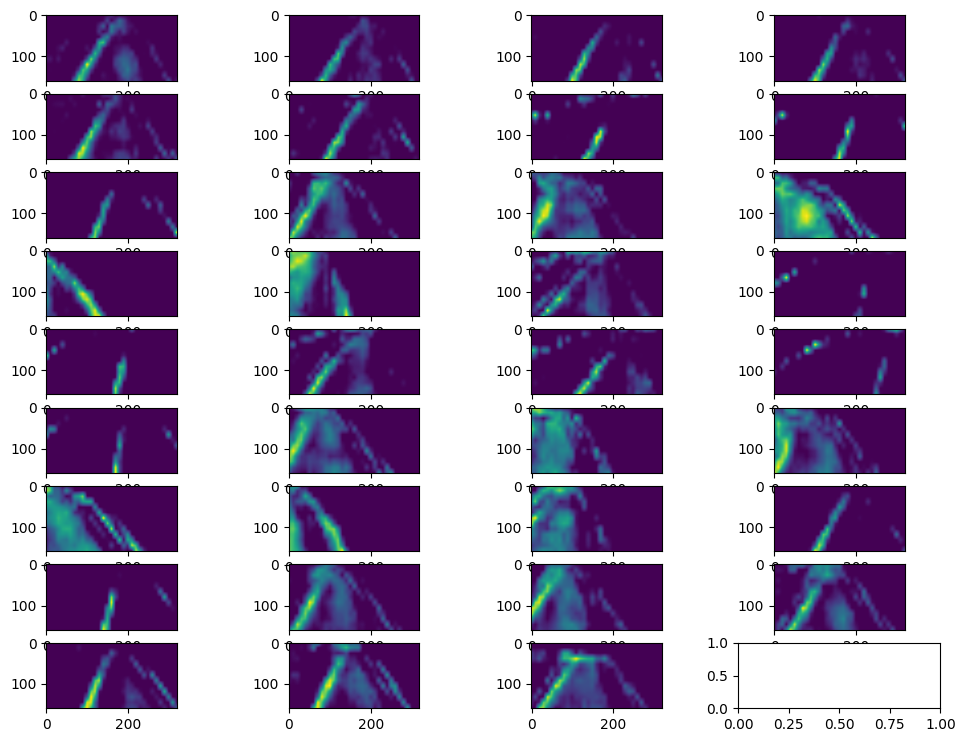

In [41]:
attention_manager = AttentionManager(simulation_name=None)
processed_image_yuv = np.asarray(processed_image_yuv, dtype = 'float32')

xai_method = "GradCAM++"
heat_map = attention_manager.single_attention_map(preprocessed_image = processed_image_yuv, 
                                                  attention_type=xai_method)
ncol = 4
nrow = 9
f, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=(12, 9))
for i in range(heat_map.shape[0]):
    ax[int((i-i%ncol)/ncol), i%ncol].imshow(heat_map[i])  #

# Single image

Text(0.5, 1.0, 'right lane')

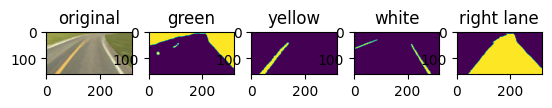

In [25]:
idx = 0

img = processed_image[idx]
img_yuv = processed_image_yuv[idx]

green_mask = Segment.color_mask(img, color="g")
yellow_mask = Segment.color_mask(img, color="y")
white_mask = Segment.color_mask(img, color="w")
road_mask, right_lane_mask = Segment.right_lane(yellow_mask, green_mask)

f, ax = plt.subplots(nrows=1, ncols=5)

ax[0].imshow(img)
ax[0].set_title("original")
ax[1].imshow(green_mask)
ax[1].set_title("green")
ax[2].imshow(yellow_mask)
ax[2].set_title("yellow")
ax[3].imshow(white_mask)
ax[3].set_title("white")
ax[4].imshow(right_lane_mask)
ax[4].set_title("right lane")

average_intensity_right_lane 0.4041319787502289
average_intensity_left_lane 0.2698269486427307
average_intensity_yellow 0.7213553786277771
average_intensity_white 0.21604742109775543
average_intensity_green 0.16404518485069275


(0.40413198, 0.26982695, 0.7213554, 0.21604742, 0.16404518)

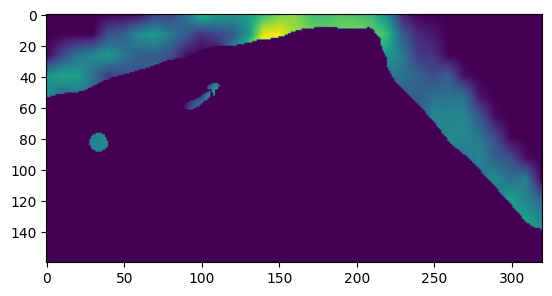

In [38]:
result = cv2.bitwise_or(heat_map[0], heat_map[0], mask = green_mask) 
plt.imshow(result)

def average_intensity(heat_map, green_mask, yellow_mask, white_mask,
                      road_mask, right_lane_mask, detail = True):
    average_intensity_right_lane = np.mean(heat_map[right_lane_mask>0])
    average_intensity_left_lane = np.mean(heat_map[road_mask - right_lane_mask>0])
    average_intensity_yellow = np.mean(heat_map[yellow_mask>0])
    average_intensity_white = np.mean(heat_map[white_mask>0])
    average_intensity_green = np.mean(heat_map[green_mask>0])

    if detail:
        print(f"average_intensity_right_lane {average_intensity_right_lane}")
        print(f"average_intensity_left_lane {average_intensity_left_lane}")
        print(f"average_intensity_yellow {average_intensity_yellow}")
        print(f"average_intensity_white {average_intensity_white}")
        print(f"average_intensity_green {average_intensity_green}")

    return (average_intensity_right_lane, average_intensity_left_lane, average_intensity_yellow,
            average_intensity_white, average_intensity_green)

average_intensity(heat_map[0], green_mask, yellow_mask, white_mask,road_mask, right_lane_mask, detail = True)

In [ ]:

def enumerate_folder(time_start, time_end , detail: bool = False):
    dir = "./simulations"

    folder_glob = os.path.join(dir, "24-*")
    folder_list = []
    folder_list.extend(glob.glob(folder_glob))
    folder_list = [i[14:] for i in folder_list]
    # folder_list_all = os.listdir(dir)
    folder_list = sorted(folder_list, key=lambda x: x[:14])
    
    time_start = datetime.strptime(timestamp[0], '%y-%m-%d-%H-%M')
    time_end = datetime.strptime(timestamp[1], '%y-%m-%d-%H-%M')
    assert time_start<time_end, "time_start must be earlier than time_end"
    
    for folder_name in folder_list:
        time_str = datetime.strptime(folder_name[:14], '%y-%m-%d-%H-%M')
        if time_start <= time_str <= time_end:
            print("--------------------------------------------")
            print("Find folder " + folder_name)
            folder_path = os.path.join(dir, folder_name)

            # DO Something
            #print(get_cte_mse(folder_path, detail))


